# Network Modeling with SEIRS+ Notebook 

In [32]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from seirsplus.models import *
from seirsplus.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *
from network_utils import *
from stats_utils import *
from intervention_utils import *
from camp_params import *
import pickle as pkl

In [33]:
n_pop = 18700

# Grid info for isoboxes
dims_isoboxes = (29, 28)  # 812

# Grid info for tents
dims_block1 = (20, 67)  # 1340
dims_block2 = (53, 15)  # 795
dims_block3 = (19, 28)  # 532

# Isoboxes
pop_isoboxes = 8100
pop_per_isobox = 10
n_isoboxes = dims_isoboxes[0]*dims_isoboxes[1]

# Tents
n_tents = 2650
pop_tents = 10600
pop_per_tent = 4

# Others 
n_bathrooms = 144
n_ethnic_groups = 8

# We define neighboring structures within a range of 2 in the structure grid
proximity = 2

# Define the maximum population per structures (tents and isoboxes) drawn from a poisson distribution
max_pop_per_struct = list(poisson.rvs(mu=pop_per_isobox, size=n_isoboxes))
max_pop_per_struct = max_pop_per_struct + list(poisson.rvs(mu=pop_per_tent, size=dims_block1[0]*dims_block1[1]))
max_pop_per_struct = max_pop_per_struct + list(poisson.rvs(mu=pop_per_tent, size=dims_block2[0]*dims_block2[1]))
max_pop_per_struct = max_pop_per_struct + list(poisson.rvs(mu=pop_per_tent, size=dims_block3[0]*dims_block3[1]))

n_structs = len(max_pop_per_struct)

# Sample the population age, and parameter rates
sample_pop = sample_population(n_pop, "data/augmented_population.csv")

### 1) Load base graph for Moria

In [34]:
# graph, nodes_per_struct = load_graph("experiments/networks/Moria_wNeighbors_4")

household_weight = 0.98
graph, nodes_per_struct = create_graph(n_structs, 0, n_pop, max_pop_per_struct, 
                                       edge_weight=household_weight, label="household",
                                       age_list=list(sample_pop["age"]),
                                       sex_list = list(sample_pop["sex"]),
                                       n_ethnicities=n_ethnic_groups)

100%|██████████| 18700/18700 [00:05<00:00, 3133.69it/s]


In [35]:
graph

In [36]:
graph, nodes_per_struct[:10]

(<networkx.classes.graph.Graph at 0x7fd868b72110>,
 [[6074, 6407, 7725, 10534, 14109, 16601, 17572],
  [2667, 3939, 9383, 15878, 15895, 16609, 17766],
  [439, 6565, 6846, 8398, 10126, 11258, 12653, 14237, 15258],
  [5269, 5581, 6053, 13761, 15374, 16077, 18545, 18576, 18586],
  [2457, 2739, 2798, 5431, 6493, 7490, 7851, 17555, 18175],
  [4355, 5852, 11628, 16497, 17897, 18122, 18250, 18501],
  [4508, 4928, 6042, 6101, 11835, 12433, 14387, 18462, 18490],
  [7186, 9166, 12149, 13641, 16002, 17748],
  [185, 1007, 2881, 5446, 5941, 10729, 11498, 15464, 15500, 16632, 18385],
  [5323, 11829, 12193, 13112, 14325, 14828, 15281]])

#### 1.1) We will add a general food queue which represents the current state of the camp

In [37]:
food_weight = 0.407
graph_1fq = connect_food_queue(graph, nodes_per_struct, food_weight, "food")

### 2) Plot the basic network degrees

Min degree: 0 Max degree: 15
Baseline:
Degree: mean = 5.38, std = 2.45, 95% CI = (1.00, 11.00)
        coeff var = 0.45
Assortativity:    1.00
Clustering coeff: 0.97



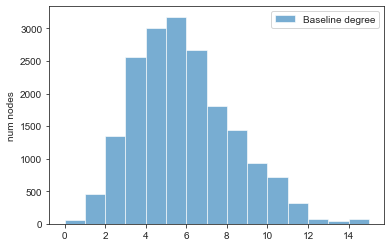

In [38]:
# Degrees without food queue, just neighbors
min_G, max_G = min_degree(graph), max_degree(graph)
print("Min degree:", min_G, "Max degree:", max_G)
# plot_degree_distn(graph, max_degree=max_G)
network_info(graph, "Baseline", plot=True)

Min degree: 0 Max degree: 25
Baseline with 1 food queue:
Degree: mean = 9.30, std = 5.45, 95% CI = (2.00, 19.52)
        coeff var = 0.59
Assortativity:    0.29
Clustering coeff: 0.75



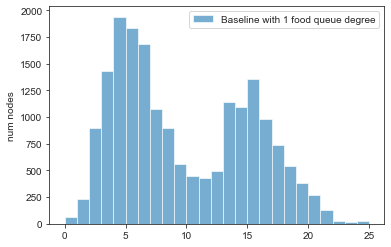

In [39]:
# Degrees with 1 food queue
min_G, max_G = min_degree(graph_1fq), max_degree(graph_1fq)
print("Min degree:", min_G, "Max degree:", max_G)
# plot_degree_distn(graph_1fq, max_degree=max_G)
network_info(graph_1fq, "Baseline with 1 food queue", plot=True)

In [40]:
neighbor_weight = 0.017
graph_1fq = connect_neighbors(graph_1fq, 0, n_isoboxes, nodes_per_struct,
                              grid_isoboxes, 2, neighbor_weight, 'friendship')
graph_1fq = connect_neighbors(graph_1fq, dims_isoboxes[0]*dims_isoboxes[1], dims_block1[0]*dims_block1[1], nodes_per_struct,
                              grid_block1, 2, neighbor_weight, 'friendship')
graph_1fq = connect_neighbors(graph_1fq, dims_block1[0]*dims_block1[1], dims_block2[0]*dims_block2[1], nodes_per_struct,
                              grid_block2, 2, neighbor_weight, 'friendship')
graph_1fq = connect_neighbors(graph_1fq, dims_block2[0]*dims_block2[1], dims_block3[0]*dims_block3[1], nodes_per_struct,
                              grid_block3, 2, neighbor_weight, 'friendship')

Min degree: 0 Max degree: 181
Baseline with neighbours:
Degree: mean = 22.61, std = 15.33, 95% CI = (2.00, 50.00)
        coeff var = 0.68
Assortativity:    0.02
Clustering coeff: 0.41



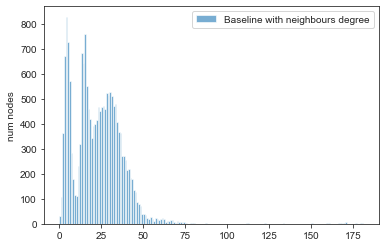

In [41]:
# Actual neighbours?
min_G, max_G = min_degree(graph_1fq), max_degree(graph_1fq)
print("Min degree:", min_G, "Max degree:", max_G)
# plot_degree_distn(graph_1fq, max_degree=max_G)
network_info(graph_1fq, "Baseline with neighbours", plot=True)

### 4) Define SEIRS model parameters

In [42]:
transmission_rate = 1.28
progression_rate = round(1/5.1, 3)
recovery_rate = 0.056 # Approx 1/18 -> Recovery occurs after 18 days
hosp_rate = round(1/11.4, 3) #1/6.3 # From Tucker Model
# crit_rate = 0.3 # From camp_params
crit_rate = list((sample_pop["death_rate"] / sample_pop["prob_symptomatic"]) / sample_pop["prob_hospitalisation"])
death_rate = 0.75

prob_global_contact = 0.2
prob_quarantine_global_contact = 1

# prob_hosp_to_critical = list(sample_pop["death_rate"]/sample_pop["prob_hospitalisation"])
prob_death = list(sample_pop["death_rate"])
prob_asymptomatic = list(1 - sample_pop["prob_symptomatic"])
prob_symp_to_hosp = list(sample_pop["prob_hospitalisation"])

init_symp_cases = 1
init_asymp_cases = 1

### 4.1) Testing out new parameters combined from seirsplus

latent period:  mean = 2.20, std = 1.09, 95% CI = (0.62, 4.76)

pre-symptomatic period:  mean = 3.01, std = 1.80, 95% CI = (0.58, 7.40)

total incubation period:  mean = 5.21, std = 2.09, 95% CI = (2.00, 10.07)



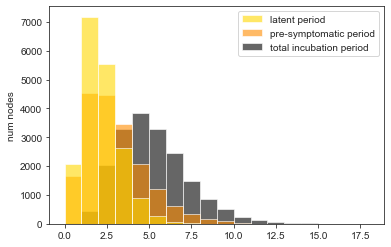

In [43]:
latentPeriod_mean, latentPeriod_coeffvar = 3.0, 0.6
SIGMA   = 1 / gamma_dist(latentPeriod_mean, latentPeriod_coeffvar, n_pop)

presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar = 2.2, 0.5
LAMDA   = 1 / gamma_dist(presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar, n_pop)

dist_info([1/LAMDA, 1/SIGMA, 1/LAMDA+1/SIGMA], ["latent period", "pre-symptomatic period", "total incubation period"], plot=True, colors=['gold', 'darkorange', 'black'], reverse_plot=True)

In [47]:
BETA.mean()

0.4481312180562816

pre-symptomatic period:  mean = 2.19, std = 1.11, 95% CI = (0.60, 4.84)

(a)symptomatic period:  mean = 4.00, std = 1.61, 95% CI = (1.51, 7.73)

total infectious period:  mean = 6.19, std = 1.95, 95% CI = (2.98, 10.55)



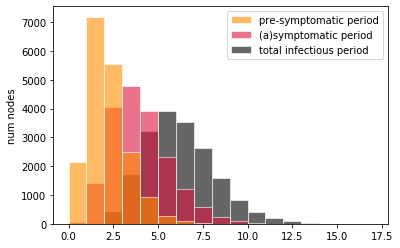

In [13]:
symptomaticPeriod_mean, symptomaticPeriod_coeffvar = 4.0, 0.4
GAMMA   = 1 / gamma_dist(symptomaticPeriod_mean, symptomaticPeriod_coeffvar, n_pop)

infectiousPeriod = 1/LAMDA + 1/GAMMA

dist_info([1/LAMDA, 1/GAMMA, 1/LAMDA+1/GAMMA], ["pre-symptomatic period", "(a)symptomatic period", "total infectious period"], plot=True, colors=['darkorange', 'crimson', 'black'], reverse_plot=True)

onset-to-hospitalization period:  mean = 10.97, std = 4.92, 95% CI = (3.58, 22.53)

hospitalization-to-discharge period:  mean = 11.02, std = 4.94, 95% CI = (3.54, 22.51)

onset-to-discharge period:  mean = 21.99, std = 6.97, 95% CI = (10.51, 37.49)



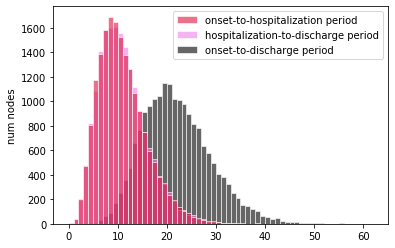

In [14]:

onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar = 11.0, 0.45
ETA     = 1 / gamma_dist(onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar, n_pop)

hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar = 11.0, 0.45
GAMMA_H = 1 / gamma_dist(hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar, n_pop)

dist_info([1/ETA, 1/GAMMA_H, 1/ETA+1/GAMMA_H], ["onset-to-hospitalization period", "hospitalization-to-discharge period", "onset-to-discharge period"], plot=True, colors=['crimson', 'violet', 'black'], reverse_plot=True)

onset-to-hospitalization period:  mean = 10.97, std = 4.92, 95% CI = (3.58, 22.53)

hospitalization-to-death period:  mean = 6.97, std = 3.14, 95% CI = (2.22, 14.28)

onset-to-death period:  mean = 17.94, std = 5.82, 95% CI = (8.41, 31.08)



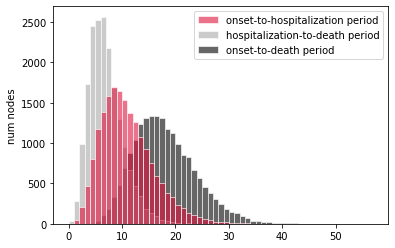

In [15]:
hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar = 7.0, 0.45
MU_H    = 1 / gamma_dist(hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar, n_pop)

dist_info([1/ETA, 1/MU_H, 1/ETA+1/MU_H], ["onset-to-hospitalization period", "hospitalization-to-death period", "onset-to-death period"], plot=True, colors=['crimson', 'darkgray', 'black'], reverse_plot=True)

In [16]:
ageGroup_pctAsymp = {"0-19": 0.8, "20+": 0.2}
PCT_ASYMPTOMATIC = get_values_per_node(ageGroup_pctAsymp, graph_1fq)
len(PCT_ASYMPTOMATIC)

18700

In [17]:

ageGroup_pctHospitalized = {'0-9':      0.0000,
                            '10-19':    0.0004,
                            '20-29':    0.0104,
                            '30-39':    0.0343,
                            '40-49':    0.0425,
                            '50-59':    0.0816,
                            '60-69':    0.118,
                            '70-79':    0.166,
                            '80+':      0.184 }

PCT_HOSPITALIZED = get_values_per_node(ageGroup_pctHospitalized, graph_1fq)
len(PCT_HOSPITALIZED)

18700

In [18]:
ageGroup_hospitalFatalityRate = {'0-9':     0.0000,
                                 '10-19':   0.3627,
                                 '20-29':   0.0577,
                                 '30-39':   0.0426,
                                 '40-49':   0.0694,
                                 '50-59':   0.1532,
                                 '60-69':   0.3381,
                                 '70-79':   0.5187,
                                 '80+':     0.7283 }
PCT_FATALITY = get_values_per_node(ageGroup_hospitalFatalityRate, graph_1fq)
len(PCT_FATALITY)

18700

Individual R0:  mean = 2.50, std = 0.49, 95% CI = (1.63, 3.55)



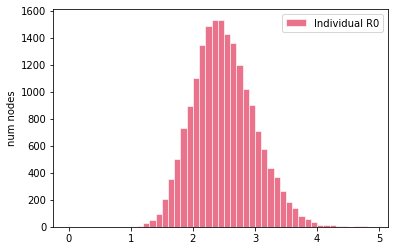

In [19]:
R0_mean     = 2.5
R0_coeffvar = 0.2

R0 = gamma_dist(R0_mean, R0_coeffvar, n_pop)

dist_info(R0, "Individual R0", bin_size=0.1, plot=True, colors='crimson')

In [20]:
BETA = 1/infectiousPeriod * R0

In [21]:
BETA_Q = BETA * (0.3/R0_mean)

In [22]:
BETA_PAIRWISE_MODE  = 'infected'

In [23]:
DELTA_PAIRWISE_MODE = 'mean'

In [24]:
ageGroup_susceptibility = {"0-19": 0.5, "20+": 1.0}
ALPHA = get_values_per_node(ageGroup_susceptibility, graph_1fq)
len(ALPHA)

18700

In [25]:
P_GLOBALINTXN = 0.2
Q_GLOBALINTXN = 0.05
INIT_EXPOSED = int(n_pop / 100)
INIT_INFECTED = int(n_pop / 100)

In [26]:
new_model = ExtSEIRSNetworkModel(G=graph_1fq, p=P_GLOBALINTXN,
                              beta=BETA, sigma=SIGMA, lamda=LAMDA, gamma=GAMMA, 
                              gamma_asym=GAMMA, eta=ETA, gamma_H=GAMMA_H, mu_H=MU_H, 
                              a=PCT_ASYMPTOMATIC, h=PCT_HOSPITALIZED, f=PCT_FATALITY,              
                              alpha=ALPHA, beta_pairwise_mode=BETA_PAIRWISE_MODE, delta_pairwise_mode=DELTA_PAIRWISE_MODE,
                              initE=INIT_EXPOSED)

In [27]:
t_steps = 200
node_states, simulation_results = run_simulation(new_model, t_steps)

Running simulation for 200 steps...

-------------------------------------------
	 S      = 18513.0
	 E      = 186.0
	 I_pre  = 1.0
	 I_sym  = 0.0
	 I_asym = 0.0
	 H      = 0.0
	 R      = 0.0
	 F      = 0.0
-------------------------------------------
	 S      = 18513.0
	 E      = 185.0
	 I_pre  = 2.0
	 I_sym  = 0.0
	 I_asym = 0.0
	 H      = 0.0
	 R      = 0.0
	 F      = 0.0
-------------------------------------------
	 S      = 18513.0
	 E      = 184.0
	 I_pre  = 3.0
	 I_sym  = 0.0
	 I_asym = 0.0
	 H      = 0.0
	 R      = 0.0
	 F      = 0.0
-------------------------------------------
	 S      = 18513.0
	 E      = 183.0
	 I_pre  = 4.0
	 I_sym  = 0.0
	 I_asym = 0.0
	 H      = 0.0
	 R      = 0.0
	 F      = 0.0
-------------------------------------------
	 S      = 18513.0
	 E      = 182.0
	 I_pre  = 5.0
	 I_sym  = 0.0
	 I_asym = 0.0
	 H      = 0.0
	 R      = 0.0
	 F      = 0.0
-------------------------------------------
	 S      = 18513.0
	 E      = 181.0
	 I_pre  = 6.0
	 I_sym  = 0.0
	 I

In [51]:
new_model.t

200.44164796691632

In [28]:
# Model name for storage + store the model params in csv
i = 0  # This is a number assigned to identify a particular network
param_combo_i = 99  # This is a number assigned to identify a particular combination of parameters
fig_name = f"BaseSympModel{i}_{param_combo_i}"
# add_model_name("experiments/model_names.csv", fig_name, household_weight, neighbor_weight, food_weight, BETA, GAMMA, LAMBDA, PCT_HOSPITALIZED, round(sum(crit_rate)/len(crit_rate), 3), death_rate, init_symp_cases, init_asymp_cases, t_steps)
# Construct results dataframe
output_df = results_to_df(simulation_results, store=True, store_name=f"experiments/results/{fig_name}.csv")

In [29]:
output_df

,Susceptible,Exposed,Infected_Presymptomatic,Infected_Symptomatic,Infected_Asymptomatic,Hospitalized,Recovered,Fatalities,T_index,Time
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5
...,...,...,...,...,...,...,...,...,...,...
38591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38592,38592
38592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38593,38593
38593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38594,38594
38594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38595,38595


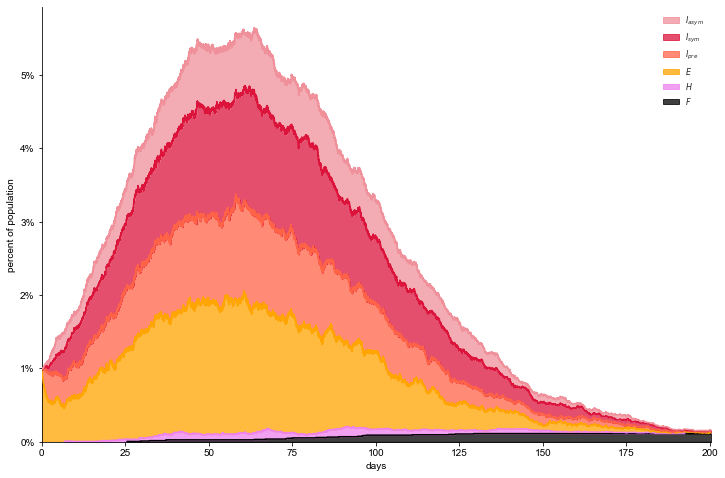

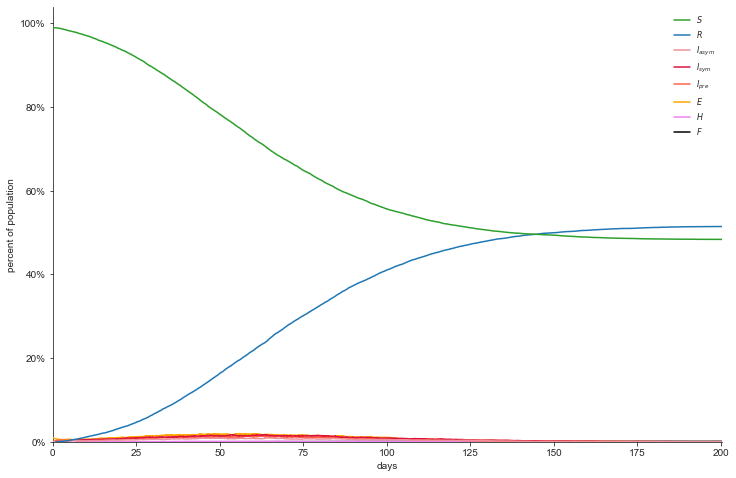

38596

In [30]:
new_model.figure_infections()
new_model.figure_basic()
new_model.tidx

### 5) Running the base model

In [ ]:
# Model construction
ref_model = ExtSEIRSNetworkModel(G=graph_1fq, p=prob_global_contact, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, a=prob_asymptomatic, f=death_rate, h=prob_symp_to_hosp, initI_sym=init_symp_cases, initI_asym=init_asymp_cases, store_Xseries=True)

In [ ]:
t_steps = 200
node_states, simulation_results = run_simulation(ref_model, t_steps)

In [ ]:
sim = pd.DataFrame(simulation_results)
sim

In [ ]:
# Model name for storage + store the model params in csv
i = 0  # This is a number assigned to identify a particular network
param_combo_i = 0  # This is a number assigned to identify a particular combination of parameters
fig_name = f"BaseSympModel{i}_{param_combo_i}"
add_model_name("experiments/model_names.csv", fig_name, household_weight, neighbor_weight, food_weight, transmission_rate, recovery_rate, progression_rate, hosp_rate, round(sum(crit_rate)/len(crit_rate), 3), death_rate, init_symp_cases, init_asymp_cases, t_steps)

In [ ]:
#here we set up a parallel computing to run experiments in parallel and aggregate the results

In [ ]:
# Construct results dataframe
output_df = results_to_df(simulation_results, store=True, store_name=f"experiments/results/{fig_name}.csv")

In [ ]:
output_df

In [ ]:
fig, ax = ref_model.figure_basic()#vlines=interventions.get_checkpoints()['t'])
fig.savefig(f"plots/{fig_name}_figBasic.png")

### 6) Define Interventions

With the interventions module, we can create an intervention with just a time step and a custom network referring to that intervention, as well as remove/edit them from the list. The method get_checkpoints() will allow us to get the dictionary to be fed to the SEIRS+ model

#### 6.1) First, define the intervention graphs

In [ ]:
# This is social distancing within the food queue 
distancing_graph = remove_edges_from_graph(graph_1fq, scale=10, edge_label_list=["food"], min_num_edges=4)

# This also includes neighbor/friendship edges
quarantine_graph = remove_edges_from_graph(graph_1fq, scale=2, edge_label_list=["food", "friendship"], min_num_edges=2)

# Create graphs with multiple sectoring of food queues - in this case, 1 and 2 queues per each block (4 and 8 food queues respectively)
graph_4fq = create_multiple_food_queues(graph, 1, food_weight, nodes_per_struct, [grid_isoboxes, grid_block1, grid_block2, grid_block3])
graph_8fq = create_multiple_food_queues(graph, 2, food_weight, nodes_per_struct, [grid_isoboxes, grid_block1, grid_block2, grid_block3])

# Create quarantine graphs for the sectored graphs
quarantine_graph_4fq = remove_edges_from_graph(graph_4fq, scale=2, edge_label_list=[f"food_{i}" for i in range(4)] + ["friendship"], min_num_edges=2)
quarantine_graph_8fq = remove_edges_from_graph(graph_8fq, scale=2, edge_label_list=[f"food_{i}" for i in range(8)] + ["friendship"], min_num_edges=2)

In [ ]:
min_D, max_D = min_degree(distancing_graph), max_degree(distancing_graph)
print("Min degree:", min_D, "Max degree:", max_D)

# As we can see, there isn't much of a difference when we only cut food-queue interactions, 
# which means we need a harder distancing policy
plot_degree_distn(distancing_graph, max_degree=max_D)

In [ ]:
min_Q, max_Q = min_degree(quarantine_graph), max_degree(quarantine_graph)
print("Min degree:", min_Q, "Max degree:", max_Q)

plot_degree_distn(quarantine_graph, max_degree=max_Q)

In [ ]:
# 4 food queues 
min_4fq, max_4fq = min_degree(graph_4fq), max_degree(graph_4fq)
print("Min degree:", min_4fq, "Max degree:", max_4fq)

plot_degree_distn(quarantine_graph, max_degree=max_4fq)

In [ ]:
# 8 food queues
min_8fq, max_8fq = min_degree(graph_8fq), max_degree(graph_8fq)
print("Min degree:", min_8fq, "Max degree:", max_8fq)

plot_degree_distn(quarantine_graph, max_degree=max_8fq)

#### 6.2) Construct the checkpoints

In [ ]:
interventions = Interventions()
reduction_percentage = 0.5

# Simulate quarantine + masks
q_start = 0
interventions.add(quarantine_graph, q_start, beta=transmission_rate*reduction_percentage)

# Simulate HALT of quarantine but people still have to wear masks
q_end = 150
interventions.add(graph_1fq, q_end, beta=transmission_rate*reduction_percentage)

# Simulate HALT of wearing masks
m_end = 200
interventions.add(graph_1fq, m_end, beta=transmission_rate)

checkpoints = interventions.get_checkpoints()

### 7) Running the model with interventions

In [ ]:
# Model construction with interventions on the model with 1 food queue
interventions_model = ExtSEIRSNetworkModel(G=graph_1fq, Q=quarantine_graph, p=prob_global_contact, q=prob_quarantine_global_contact, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, a=prob_asymptomatic, f=death_rate, h=prob_symp_to_hosp, initI_sym=init_symp_cases, initI_asym=init_asymp_cases, store_Xseries=True)

In [ ]:
t_steps = 200
intervention_node_states, intervention_results = run_simulation(interventions_model, t_steps, checkpoints)

In [ ]:
# Model name for storage + store the model params in csv
i, param_combo_i = 0, 0
fig_name = f"InterventionsBaseModel{i}_{param_combo_i}"
add_model_name("experiments/model_names.csv", fig_name, household_weight, neighbor_weight, food_weight, transmission_rate, recovery_rate, progression_rate, hosp_rate, round(sum(crit_rate)/len(crit_rate), 3), death_rate, init_symp_cases, init_asymp_cases, t_steps, f"{q_start}-{q_end}", reduction_percentage, f"{q_start}-{m_end}")


In [ ]:
output_df = results_to_df(intervention_results, store=True, store_name=f"experiments/results/{fig_name}.csv")

In [ ]:
output_df

In [ ]:
fig, ax = interventions_model.figure_basic()#vlines=interventions.get_checkpoints()['t'])
# fig.savefig(f"plots/{fig_name}_figBasic.png")

#### 7.1) Running the base model with multiple food queues

In [ ]:
# Model construction for multiple food queues but no more interventions
model_4fq = ExtSEIRSNetworkModel(G=graph_4fq, p=prob_global_contact, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, a=prob_asymptomatic, f=death_rate, h=prob_symp_to_hosp, initI_sym=init_symp_cases, initI_asym=init_asymp_cases, store_Xseries=True)

model_8fq = ExtSEIRSNetworkModel(G=graph_8fq, p=prob_global_contact, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, a=prob_asymptomatic, f=death_rate, h=prob_symp_to_hosp, initI_sym=init_symp_cases, initI_asym=init_asymp_cases, store_Xseries=True)

In [ ]:
t_steps = 200
node_states, simulation_results_4fq = run_simulation(model_4fq, t_steps)

In [ ]:
# Model name for storage
food_queue_number = 4
i = 0
fig_name = f"MultFQ{food_queue_number}_Model{i}"

add_model_name("experiments/model_names.csv", fig_name, household_weight, neighbor_weight, food_weight, transmission_rate, recovery_rate, progression_rate, hosp_rate, round(sum(crit_rate)/len(crit_rate), 3), death_rate, init_symp_cases, init_asymp_cases, t_steps)
			

In [ ]:
output_df = results_to_df(simulation_results_4fq, store=True, store_name=f"experiments/results/{fig_name}.csv")


In [ ]:
output_df

In [ ]:
fig, ax = model_4fq.figure_basic()#vlines=interventions.get_checkpoints()['t'])
# fig.savefig(f"plots/{fig_name}_figBasic.png")

In [ ]:
t_steps = 200
node_states, simulation_results_8fq = run_simulation(model_8fq, t_steps)

In [ ]:
food_queue_number = 8
i = 0
fig_name = f"MultFQ{food_queue_number}_Model{i}"

add_model_name("experiments/model_names.csv", fig_name, household_weight, neighbor_weight, food_weight, transmission_rate, recovery_rate, progression_rate, hosp_rate, round(sum(crit_rate)/len(crit_rate), 3), death_rate, init_symp_cases, init_asymp_cases, t_steps)
	

In [ ]:
output_df = results_to_df(simulation_results_8fq, store=True, store_name=f"experiments/results/{fig_name}.csv")


In [ ]:
output_df

In [ ]:
fig, ax = model_8fq.figure_basic()#vlines=interventions.get_checkpoints()['t'])
# fig.savefig(f"plots/{fig_name}_figBasic.png")

#### 7.2) Running the multiple food queues model with interventions

In [ ]:
# Model construction for multiple food queues in addition to other interventions
interventions_model_4fq = ExtSEIRSNetworkModel(G=graph_4fq, Q=quarantine_graph_4fq, p=prob_global_contact, q=prob_quarantine_global_contact, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, a=prob_asymptomatic, f=death_rate, h=prob_symp_to_hosp, initI_sym=init_symp_cases, initI_asym=init_asymp_cases, store_Xseries=True)

interventions_model_8fq = ExtSEIRSNetworkModel(G=graph_8fq, Q=quarantine_graph_8fq, p=prob_global_contact, q=prob_quarantine_global_contact, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, a=prob_asymptomatic, f=death_rate, h=prob_symp_to_hosp, initI_sym=init_symp_cases, initI_asym=init_asymp_cases, store_Xseries=True)

In [ ]:
## Interventions for graph with 4 food queues 
interventions.clear()

# Amount by which wearing masks reduces the transmission rate
reduction_percentage = 0.3

# Simulate quarantine + masks
q_start = 0
interventions.add(quarantine_graph_4fq, q_start, beta=transmission_rate*reduction_percentage)

# Simulate HALT of quarantine but people still have to wear masks
q_end = 150
interventions.add(graph_4fq, q_end, beta=transmission_rate*reduction_percentage)

# Simulate HALT of wearing masks
m_end = 200
interventions.add(graph_4fq, m_end, beta=transmission_rate)

checkpoints = interventions.get_checkpoints()

In [ ]:
t_steps = 200
node_states, intervention_results_4fq = run_simulation(interventions_model_4fq, t_steps)

In [ ]:
# Model name for storage - adjust accordingly to interventions
i = 0
food_queue_number = 4
fig_name = f"InterventionsMultFQ{food_queue_number}_Model{i}"

add_model_name("experiments/model_names.csv", fig_name, household_weight, neighbor_weight, food_weight, transmission_rate, recovery_rate, progression_rate, hosp_rate, round(sum(crit_rate)/len(crit_rate), 3), death_rate, init_symp_cases, init_asymp_cases, t_steps, f"{q_start}-{q_end}", reduction_percentage, f"{q_start}-{m_end}")


In [ ]:
output_df = results_to_df(intervention_results_4fq, store=True, store_name=f"experiments/results/{fig_name}.csv")

In [ ]:
output_df

In [ ]:
fig, ax = interventions_model_4fq.figure_basic()#vlines=interventions.get_checkpoints()['t'])
# fig.savefig(f"plots/{fig_name}_figBasic.png")

In [ ]:
## Interventions for graph with 8 food queues 
interventions.clear()

# Amount by which wearing masks reduces the transmission rate
reduction_percentage = 0.3

# Simulate quarantine + masks
q_start = 0
interventions.add(quarantine_graph_8fq, q_start, beta=transmission_rate*reduction_percentage)

# Simulate HALT of quarantine but people still have to wear masks
q_end = 150
interventions.add(graph_8fq, q_end, beta=transmission_rate*reduction_percentage)

# Simulate HALT of wearing masks
m_end = 200
interventions.add(graph_8fq, m_end, beta=transmission_rate)

checkpoints = interventions.get_checkpoints()

In [ ]:
t_steps = 200
node_states, interventions_results_8fq = run_simulation(interventions_model_8fq, t_steps)

In [ ]:
i = 0
food_queue_number = 8
fig_name = f"InterventionsMultFQ{food_queue_number}_Model{i}"

add_model_name("experiments/model_names.csv", fig_name, household_weight, neighbor_weight, food_weight, transmission_rate, recovery_rate, progression_rate, hosp_rate, round(sum(crit_rate)/len(crit_rate), 3), death_rate, init_symp_cases, init_asymp_cases, t_steps, f"{q_start}-{q_end}", reduction_percentage, f"{q_start}-{m_end}")

In [ ]:
output_df = results_to_df(intervention_results_8fq, store=True, store_name=f"experiments/results/{fig_name}.csv")

In [ ]:
output_df

In [ ]:
fig, ax = interventions_model_8fq.figure_basic()#vlines=interventions.get_checkpoints()['t'])
fig.savefig(f"plots/{fig_name}_figBasic.png")